## Music Genre Classification using a CNN with MFCC Images


### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/ANN&DL Challenges/Data/genres_original"

Mounted at /gdrive
/gdrive/My Drive/ANN&DL Challenges/Data/genres_original


### Import Libraries


In [2]:
import tensorflow as tf
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [3]:
seed = 42
import pandas as pd
import librosa
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow import keras as tfk
from keras import layers as tfkl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

### Load and preprocess the dataset

GTZAN dataset preprocessing. The 30-second audio files are decoded,
downsampled to **16 kHz** and converted to mono. Each track is then
split into **3-second segments**, so in principle 1,000 original
tracks would yield 10,000 segments (30 / 3 per track).

In practice, a small number of audio files are slightly shorter or
corrupted, so the final number of valid 3-second segments is **9,990**
instead of 10,000. These segments, together with their genre labels,
are used as input for MFCC extraction and model training.

In [4]:
sample_rate = 16000  
path = "/gdrive/My Drive/ANN&DL Challenges/Data/genres_original"
segment_duration = 3
audio_data = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.wav'):
            audio_path = os.path.join(root, file)
            audio, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
            num_segments = len(audio) // (sample_rate * segment_duration)
            for i in range(num_segments):
                start = i * sample_rate * segment_duration
                end = (i + 1) * sample_rate * segment_duration
                segment = audio[start:end]
                audio_data.append(segment)
print(len(audio_data))

9990


The labels are extracted from a CSV file (`features_3_sec.csv`)
containing pre-computed features and the **genre label** for each
3-second segment. From this file we read the last column, which stores
the categorical labels, and inspect the **class distribution** (number
of segments per genre).

This step allows us to verify that all 10 genres are present, that
there are no missing labels and that the dataset is reasonably
balanced across classes.


In [5]:
csv_path = "/gdrive/My Drive/ANN&DL Challenges/Data/features_3_sec.csv"  # Percorso al file CSV

df = pd.read_csv(csv_path)
labels = df.iloc[:,-1]
unique, count = np.unique(labels, return_counts=True)

print("Total Labels",labels.shape[0])
for i,u in enumerate(unique):
    print(f'{unique[i]}: {count[i]} samples')

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

Total Labels 9990
blues: 1000 samples
classical: 998 samples
country: 997 samples
disco: 999 samples
hiphop: 998 samples
jazz: 1000 samples
metal: 1000 samples
pop: 1000 samples
reggae: 1000 samples
rock: 998 samples


### Feature extraction from the audio

For each 3-second audio segment we compute **Mel-Frequency Cepstral
Coefficients (MFCCs)**, which provide a compact representation of the
short-term spectral envelope of the signal.

We stack the MFCCs over time to obtain a 2D time–frequency matrix
of shape roughly `(n_mfcc, n_frames)` (e.g. 20 × 94). This matrix
is interpreted as a **single-channel image** (`height × width × 1`)
and used as input for a 2D CNN.

This representation allows the CNN to exploit the full time–frequency
structure of the signal, similarly to how convolutional networks
process images.


In [6]:
n_bands=20
sample_rate=16000

In [7]:
audio_mfcc_images=[]
for audio in audio_data:
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_bands)
    mfcc_normalized = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    audio_mfcc_images.append(mfcc)


In [8]:
audio_mfcc_images = np.array(audio_mfcc_images)

### Train, Validation and Test Sets

The dataset is divided into three subsets:

- the **training set**, used to fit the model parameters
- the **validation set**, used for model selection and early stopping
- the **test set**, used only at the end to evaluate the final
  performance on unseen data

First, we split the full dataset into a combined *train+validation*
set and a separate test set (e.g. 20% of the segments, stratified by
label). Then, we further split the *train+validation* set into:

- a **training set**
- a **validation set** of comparable size to the test set,

while preserving the original class distribution at each step
(stratified splits).


In [9]:
# Split the dataset into a combined training and validation set, and a separate test set
M_train_val, M_test, y_train_val, y_test = train_test_split(
    audio_mfcc_images, 
    labels, 
    test_size = 0.2,
    random_state=seed,
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
M_train, M_val, y_train, y_val = train_test_split(
    M_train_val,
    y_train_val,
    test_size = len(M_test), 
    random_state=seed,
    stratify = y_train_val
)

### Inspection of Dataset Shapes and Distributions


In [10]:
print("Training set data and label shape:", M_train.shape, y_train.shape)
print("Validation set data and label shape:", M_val.shape, y_val.shape)
print("Test set data and label shape:", M_test.shape, y_test.shape)

Training set data and label shape: (5994, 20, 94) (5994,)
Validation set data and label shape: (1998, 20, 94) (1998,)
Test set data and label shape: (1998, 20, 94) (1998,)


### Reshaping for CNN Input

Before feeding the data to the CNN, we add a singleton channel
dimension so that each MFCC “image” has shape `(n_mfcc, n_frames, 1)`,
as expected by 2D convolutional layers.

In [11]:
M_train= np.expand_dims(M_train , axis=-1)
M_val= np.expand_dims(M_val, axis=-1)
M_test= np.expand_dims( M_test, axis=-1)
y_train= np.expand_dims(y_train , axis=-1)
y_val= np.expand_dims(y_val, axis=-1)
y_test= np.expand_dims(y_test, axis=-1)
print("Training set data and label shape:", M_train.shape, y_train.shape)
print("Validation set data and label shape:", M_val.shape, y_val.shape)
print("Test set data and label shape:", M_test.shape, y_test.shape)

Training set data and label shape: (5994, 20, 94, 1) (5994, 1)
Validation set data and label shape: (1998, 20, 94, 1) (1998, 1)
Test set data and label shape: (1998, 20, 94, 1) (1998, 1)


In [12]:
print('Check occurrences distribution over the 3 sets classes:')
print(pd.DataFrame(y_train, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_val, columns=['class'])['class'].value_counts())
print(pd.DataFrame(y_test, columns=['class'])['class'].value_counts())

Check occurrences distribution over the 3 sets classes:
0    600
8    600
7    600
6    600
5    600
3    599
4    599
1    599
2    599
9    598
Name: class, dtype: int64
5    200
8    200
0    200
6    200
1    200
9    200
3    200
7    200
2    199
4    199
Name: class, dtype: int64
0    200
8    200
6    200
5    200
3    200
7    200
9    200
4    200
2    199
1    199
Name: class, dtype: int64


In [13]:
# Convert textual labels to numeric and categorical format using one-hot encoding
# We have the unique values in the ndarray "unique"
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

### CNN Model and Training

The model architecture consists of three **convolutional layers** for feature extraction, followed by **max pooling layers** for dimensionality reduction. **Batch normalization** is used to stabilize the trainThe model architecture consists of three **Conv2D–BatchNorm–ReLU**
blocks for feature extraction, each followed by max pooling to reduce
the spatial dimensions. After the convolutional stack, we apply
dropout for regularization and use fully connected **dense layers**
for classification.

Key components:
- 2D convolutions on MFCC “images” (time–frequency representation)
- Batch Normalization and ReLU activations
- MaxPooling2D layers to progressively reduce the feature map size
- Dropout to mitigate overfitting
- One or more dense layers for high-level feature combination
- Final softmax output layer with 10 units (one per genre)
ing process, while **dropout regularization** and **L2 regularization** are employed to prevent overfitting. The model is finalized with two **dense layers** for classification.

In [14]:
# Define key model parameters
input_shape = M_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 64                # Batch size for training
epochs = 1000          # Number of training epochs
learning_rate = 1e-3

In [15]:
def build_CNN(input_shape, output_shape, seed=42):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    # First layer
    conv1 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        name='conv1'
    )(input_layer)

    batchnorm1 = tfkl.BatchNormalization()(conv1)
    activation1 = tfkl.Activation('relu')(batchnorm1)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2, 2 ),
        name='mp1'
    )(activation1)

    # Second layer
    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        name='conv2'
    )(pool1)

    batchnorm2 = tfkl.BatchNormalization()(conv2)
    activation2 = tfkl.Activation('relu')(batchnorm2)

    pool2 = tfkl.MaxPooling2D(
        pool_size=(2, 2 ),
        name='mp2'
    )(activation2)

    # Third layer
    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        name='conv3'
    )(pool2)

    batchnorm3 = tfkl.BatchNormalization()(conv3)
    activation3 = tfkl.Activation('relu')(batchnorm3)

    pool3 = tfkl.MaxPooling2D(
        pool_size=(2, 2 ),
        name='mp3'
    )(activation3)


    flattening_layer = tfkl.Flatten(
        name='flatten'
    )(pool3)

    dropout = tfkl.Dropout(0.5)(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=64,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        name='dense'
    )(dropout)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    return model

In [16]:
# Build the CNN model and display its summary
model = build_CNN(input_shape, output_shape, seed=seed)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 94, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 20, 94, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 20, 94, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 20, 94, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 10, 47, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 10, 47, 64)        36928     
                                                               

In [17]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_lr=1e-4, mode='max')
]

In [18]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [19]:
# Train the model and save its history
history = model.fit(
    x=M_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(M_val, y_val),
    callbacks=callbacks
).history


Epoch 1/1000
94/94 [==============================] - 9s 25ms/step - loss: 2.8600 - accuracy: 0.3048 - val_loss: 2.6930 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 2/1000
94/94 [==============================] - 1s 15ms/step - loss: 1.9439 - accuracy: 0.4751 - val_loss: 2.0458 - val_accuracy: 0.4009 - lr: 0.0010
Epoch 3/1000
94/94 [==============================] - 1s 12ms/step - loss: 1.5821 - accuracy: 0.5561 - val_loss: 1.5436 - val_accuracy: 0.5546 - lr: 0.0010
Epoch 4/1000
94/94 [==============================] - 1s 11ms/step - loss: 1.3823 - accuracy: 0.6048 - val_loss: 1.2795 - val_accuracy: 0.6216 - lr: 0.0010
Epoch 5/1000
94/94 [==============================] - 1s 11ms/step - loss: 1.2346 - accuracy: 0.6361 - val_loss: 1.3654 - val_accuracy: 0.5826 - lr: 0.0010
Epoch 6/1000
94/94 [==============================] - 1s 11ms/step - loss: 1.1354 - accuracy: 0.6675 - val_loss: 1.1418 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 7/1000
94/94 [==============================] - 1s 11ms/st

In [20]:
model.save('CNN_MFCC')
del model

In [21]:
# Load the saved model
model = tfk.models.load_model('CNN_MFCC')

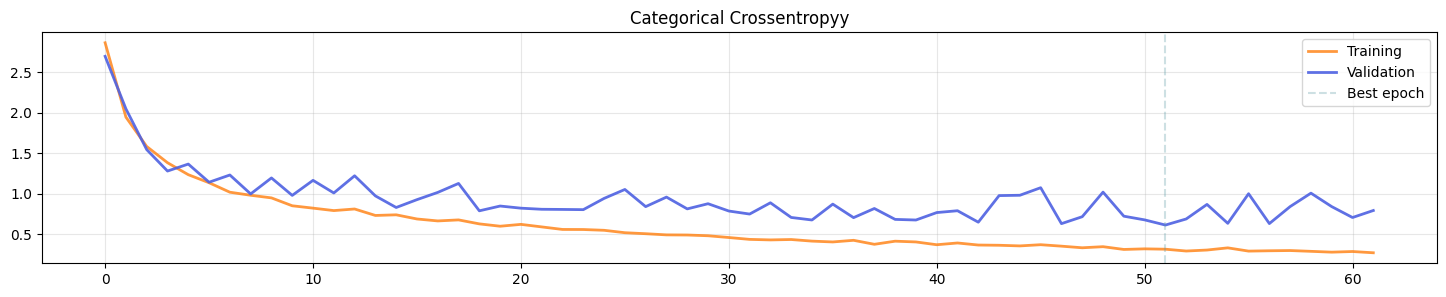

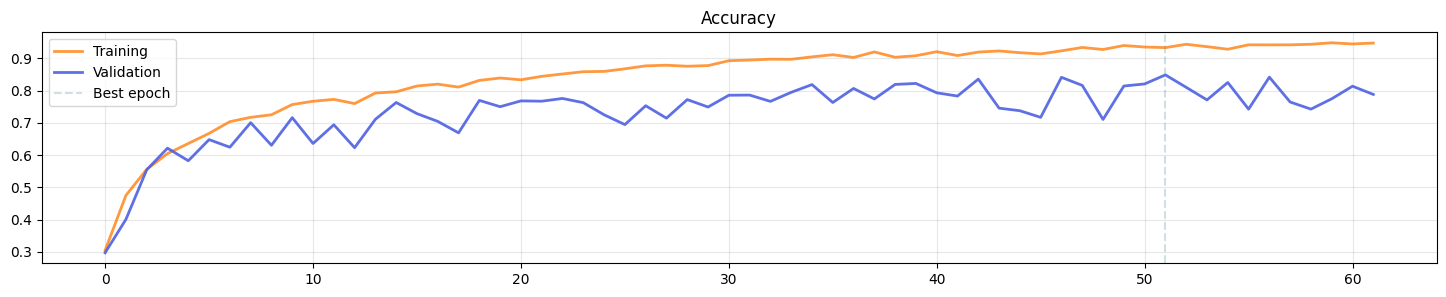

In [22]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#4D61E2', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropyy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#4D61E2', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Performance on Test Set

We evaluate the trained MFCC-based CNN on the held-out test set,
reporting accuracy, precision, recall and F1-score, as well as the
confusion matrix to inspect typical confusions between genres.

In [23]:
# Predict labels for the entire test set
predictions = model.predict(M_test, verbose=0)
print("Predictions Shape:", predictions.shape)


Predictions Shape: (1998, 10)


Accuracy: 0.8463
Precision: 0.8456
Recall: 0.8464
F1: 0.8444


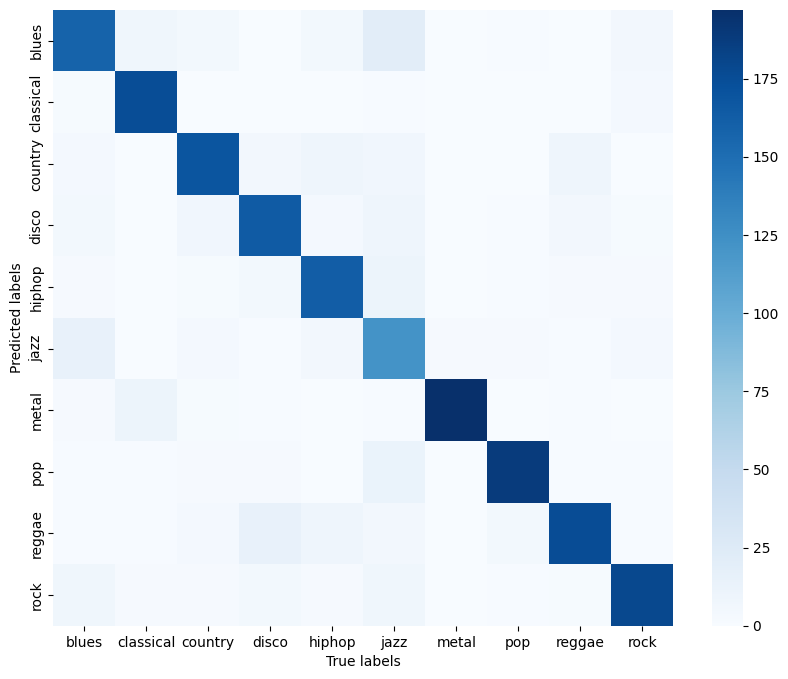

In [24]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
label_map= {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

sns.heatmap(cm.T, xticklabels=list(label_map.values()), yticklabels=list(label_map.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()